In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import json
from collections import Counter
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

import torchvision
import torchvision.transforms as transforms
import torchsummary

from tqdm import tqdm
from tqdm.notebook import tqdm

from torchviz import make_dot

from torchmetrics import Recall, Precision, F1Score
from torchmetrics.classification import BinaryRecall, BinaryPrecision, BinaryF1Score

In [2]:
base_path = "C:\\Users\\johnn\\Desktop\\Repos\\Capstonfire\\new_full_dataset"
#base_path_maria = "C:\\Users\\Maria Carolina\\Documents\\GitHub\\Capstonfire\\trained_models\\fire_dataset"

# Creating our first model

With our training and testing datasets, we can now start creating CNN models to predict fire images.

Before starting on the model, we first need to define the Dataset class, in order to create the Dataloaders. We will create this class having as basis the structure of the FIRE dataset: two folders, "fire_images" and "non_fire_images", with the label of the image being given by the folder that it is present on.

The dataset will have two labels, "fire" and "non_fire", which is defined in the constructor of the class. Likewise, a transformer is required for the images in the dataset to be compatible with the model inputs. _load_data will add the appropriate label to all images, based on the folder that they are currently at. The "getitem" function transforms the image at the given index with the given transformer before handing it over as output, along with its label.

In [4]:
class FireDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        # Store the folder names in a dictionary as the class names alongside the class numeric label
        self.class_to_idx = {} 
        for i, cls in enumerate(self.classes):
            self.class_to_idx[cls] = i

        self.data = self._load_data()

    def _load_data(self):
        data = []
        for class_name in self.classes: # Fetch the folders through the class name
            class_path = os.path.join(self.root_dir, class_name)
            for filename in os.listdir(class_path): # Fetch the images inside each folders
                img_path = os.path.join(class_path, filename) # Obtain the name of the current image
                data.append((img_path, self.class_to_idx[class_name])) # Add the image to a list paired with its class' numeric label
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx): # data[idx]
        img_path, label = self.data[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label

For now let's make the transformer simple: resize the image into a 256x256 square and convert it into a tensor.

In [6]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

dataset = FireDataset(base_path, transform=transform)

Let's check if it worked.

Label: 0
Image shape: torch.Size([3, 256, 256])


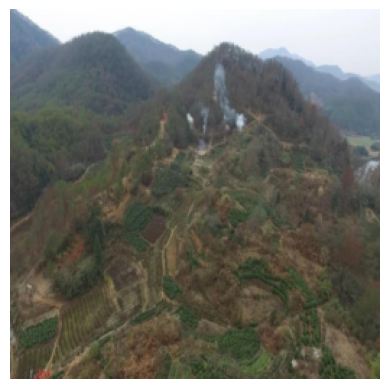

In [7]:
# Access an image and its label
img, label = dataset[0]
print("Label:", label)
# The image is a PyTorch tensor
print("Image shape:", img.shape)

# Convert the PyTorch tensor to a NumPy array and permute dimensions if necessary
img_np = img.permute(1, 2, 0).numpy()

# Display the image using Matplotlib
plt.imshow(img_np)
plt.axis('off')
plt.show()

Nice. Let's create the dataloaders. We will create 3: a training loader, a validation loader to check the training progression and a testing set to create a first testing scenario after the model finished training.

In [ ]:
df_full = pd.DataFrame(columns=['path', 'label', 'width', 'height'])

for dirname, _, filenames in os.walk(base_path):
    for filename in filenames:
        image_shape = Image.open(dirname + "\\" + filename).size
        height = image_shape[1]
        width = image_shape[0]
        df_full = pd.concat([df_full, pd.DataFrame([[os.path.join(dirname, filename),'fire', width, height]], columns=['path','label', 'width', 'height'])], axis=0)

for dirname, _, filenames in os.walk(base_path):
    for filename in filenames:
        image_shape = Image.open(dirname + "\\" + filename).size
        height = image_shape[1]
        width = image_shape[0]
        df_full = pd.concat([df_full, pd.DataFrame([[os.path.join(dirname, filename),'no fire', width, height]],columns=['path','label', 'width', 'height'])], axis=0)

df_full

In [8]:
batch_size = 50

In [9]:
train_size = 0.7
val_size = 0.2
test_size = 0.1

train_dataset, val_dataset, test_dataset = random_split(dataset=dataset, lengths=[train_size, val_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [20]:
len(train_loader.dataset)

4842

Looks like the split worked. We can now get on with the model.

For our first model we followed the approach done by our professor Simão in the CNN class: a 4-layer network with 2 convolutional 2D layers and 2 Linear layers, with a maxpool activation function for the conv2d layers and ReLu for the first linear layer. 

We will train the models with CUDA, to make the training faster.

In [21]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5) # to capture basic patterns from the image
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)# to capture basic patterns from the previous patterns (results in capturing more complex patterns from the original image)
        self.fc1 = nn.Linear(74420, 50) # 1000 = 20 * 50 * 1 -> conv2.output * batch_size * ?
        self.fc2 = nn.Linear(50, 2) # DNN > WNN; also 2 classes

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 74420)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #return F.log_softmax(x, dim=1)
        return x

model = SimpleCNN().to(device)

In [23]:
# Simple summary to check that the passage from the last Conv2D layer to the first Linear layer is working properly
torchsummary.summary(model=model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 10, 252, 252]             760
            Conv2d-2         [-1, 20, 122, 122]           5,020
            Linear-3                   [-1, 50]       3,721,050
            Linear-4                    [-1, 2]             102
Total params: 3,726,932
Trainable params: 3,726,932
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 7.12
Params size (MB): 14.22
Estimated Total Size (MB): 22.08
----------------------------------------------------------------


In [24]:
model_name = "dummy_cnn_full"

In [25]:
x = torch.randn(50, 3, 256, 256).to(device)  # A dummy input tensor to pass through the model
y = model(x)

dot = make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)]))
dot.render('model details/' + model_name + '-model_visualization', format='png')

'model details\\dummy_cnn_full-model_visualization.png'

For our first training we used the simplest criterion and optimizers: CrossEntropyLoss (which is for multi-class scenarios), and "Simple Gradient Descent" (SDG). We likewise added a training progression reader to evaluate how the model changed overtime.

In [26]:
# Step 2: Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0003, momentum=0.9)

In [27]:
history = {
    "avg_train_loss_list": [],
    "train_accuracy_list": [],
    "avg_val_loss_list": [],
    "val_accuracy_list": []
}

In [30]:
pretrained_models_path = os.path.join(base_path,"..", "trained_models")
hist_file_path = os.path.join(pretrained_models_path, model_name + '.json')

In [31]:
 # Step 3: Training Loop
 # avoid loop if the model was already trained

skip_saving : bool = False
if model_name + '.pt' in os.listdir(pretrained_models_path):
    skip_saving = True
    model.load_state_dict(torch.load(os.path.join(pretrained_models_path, model_name +'.pt')))
    
    with open(hist_file_path, 'r') as json_file:
        history = json.load(json_file)

# if model was never trained, enter loop
else:
    num_epochs = 10
    for epoch in tqdm(list(range(num_epochs))):
        model.train()

        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # zero the parameter gradients
            outputs = model(inputs)  # forward
            loss = criterion(outputs, labels)  # calculate loss
            loss.backward()  # backward
            optimizer.step()  # optimize

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
            
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            correct_val = 0
            total_val = 0
            val_loss = 0.0

            for inputs_val, labels_val in val_loader:
                inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
                outputs_val = model(inputs_val)
                loss_val = criterion(outputs_val, labels_val)

                _, predicted_val = torch.max(outputs_val, 1)
                total_val += labels_val.size(0)
                correct_val += (predicted_val == labels_val).sum().item()

                val_loss += loss_val.item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct_val / total_val

        history["avg_train_loss_list"].append(avg_train_loss)
        history["train_accuracy_list"].append(train_accuracy)
        history["avg_val_loss_list"].append(avg_val_loss)
        history["val_accuracy_list"].append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
            f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
            f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    print('Finished Training')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Train Loss: 0.6807, Train Accuracy: 0.5989, Validation Loss: 0.6696, Validation Accuracy: 0.6329
Epoch [2/10], Train Loss: 0.6547, Train Accuracy: 0.6309, Validation Loss: 0.6387, Validation Accuracy: 0.6113


KeyboardInterrupt: 

Let's save the model and the training progression for future analysis.

In [63]:
if not skip_saving:
    # save pytorch model
    torch.save(model.state_dict(), os.path.join(pretrained_models_path, model_name + '.pt'))

    # Write history dictionary to a JSON file
    with open(hist_file_path, 'w+') as json_file:
        json.dump(history, json_file)

How was the training?

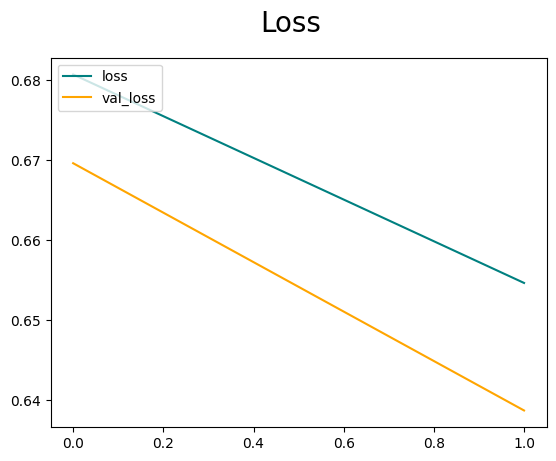

In [32]:
fig = plt.figure()
plt.plot(history["avg_train_loss_list"], color='teal', label='loss')
plt.plot(history["avg_val_loss_list"], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

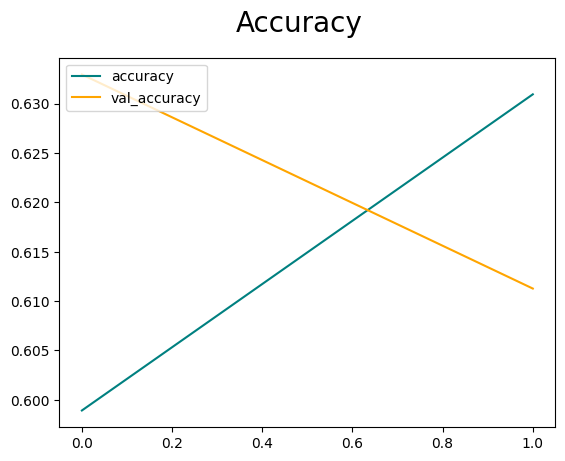

In [33]:
fig = plt.figure()
plt.plot(history["train_accuracy_list"], color='teal', label='accuracy')
plt.plot(history["val_accuracy_list"], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Looks like the model was barely improving at first, but then started to jump to better values. This behaviour might be due to the optimizer used, which is incredibly simple.

Let's check what matters: can it predict fire images?

In [34]:
recall = Recall(task='multiclass',num_classes=2).to(device)
precision = Precision(task='multiclass',num_classes=2).to(device)
f1 = F1Score(task='multiclass',num_classes=2).to(device)

with torch.no_grad():
    for data in tqdm(test_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)  # forward
        #predicted_binary = (torch.sigmoid(outputs) > 0.5).float()
        predictions = torch.argmax(outputs, dim=1)

        recall.update(predictions, labels)
        precision.update(predictions, labels)
        f1.update(predictions, labels)

print('Recall on the test set: %.2f' % (recall.compute()))
print('Precision on the test set: %.2f' % (precision.compute()))
print('F1 Score on the test set: %.2f' % (f1.compute()))

  0%|          | 0/14 [00:00<?, ?it/s]

Recall on the test set: 0.64
Precision on the test set: 0.64
F1 Score on the test set: 0.64


In [36]:
test_path = os.path.join(base_path,"..", "test dataset")

custom_test_loader = DataLoader(FireDataset(test_path, transform=transform), batch_size=batch_size, shuffle=False)

with torch.no_grad():
    for data in tqdm(custom_test_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)  # forward
        #predicted_binary = (torch.sigmoid(outputs) > 0.5).float()
        predictions = torch.argmax(outputs, dim=1)

        recall.update(predictions, labels)
        precision.update(predictions, labels)
        f1.update(predictions, labels)
        
print('Recall on the test set: %.2f' % (recall.compute()))
print('Precision on the test set: %.2f' % (precision.compute()))
print('F1 Score on the test set: %.2f' % (f1.compute()))

  0%|          | 0/60 [00:00<?, ?it/s]

Recall on the test set: 0.39
Precision on the test set: 0.39
F1 Score on the test set: 0.39


Wow, not that bad for a first algorithm. Let's check if it can predict fire in videos.

In [37]:
import cv2
import random

In [38]:
def run_video(filename, model : torch.nn.Module, transforms: transforms):
    """
        Inputs: 
        - filename: the path to the video to run
        - model: the CNN model to make the prediction on each frame of the video
        - transforms: the transform to be applied to each frame of the video in order to make it
          compatible with the model
        Outputs: 
        - Arr[is_fire_percentage, is_not_fire_percentage]
    """

    predictions = [0, 0]
    total_frames = 1

    cap = cv2.VideoCapture(filename)

    while True:
        ret, image = cap.read()

        # Check if the frame was successfully read
        if not ret:
            break
        
        # Make a prediction for the current frame if a model was given
        if model != None and transforms != None:
            draw = image.copy()
            draw = cv2.resize(draw, (640, 480))
            draw = transforms(draw)

            outputs = model(draw)
            #prob = torch.sigmoid(outputs)
            _, prob = torch.max(outputs, 1)

            if prob > 0.5:
                color = (0, 255, 0)
                predictions[1] += 1
            else:
                color = (0, 0, 255)
                predictions[0] += 1
            
            cv2.putText(image, "fire" if prob.item() == 0 else "non_fire", (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

        # Display the frame
        cv2.imshow('framename', image)

        total_frames += 1

        # Break the loop if 'q' key is pressed
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    return {'fire': predictions[0]/total_frames, 'non_fire': predictions[1]/total_frames}

In [41]:
videos_folder = os.path.join(base_path,"..", "test dataset videos")

In [42]:
os.listdir(videos_folder)

['cloud_forming',
 'cloud_forming.mp4',
 'drone_footage',
 'drone_footage.mp4',
 'firefighting',
 'firefighting.mp4',
 'forest_timelapse_2',
 'forest_timelapse_2.mp4',
 'forest_time_lapse_1',
 'forest_time_lapse_1.mp4',
 'forest_video',
 'forest_video.mp4',
 'stock_footage',
 'stock_footage.mp4',
 'storm_timelapse',
 'storm_timelapse.mp4',
 'timelapse',
 'timelapse.mp4',
 'voa_fire',
 'voa_fire.mp4']

The videos are in the odd indexes of the folder array. We can select a random odd number and observe the predictions from there.

In [54]:
random_number = random.randint(0, 19)
random_odd_number = random_number + 1 if random_number % 2 == 0 else random_number
example_video = os.path.join(videos_folder, os.listdir(videos_folder)[random_odd_number])
example_video

'C:\\Users\\johnn\\Desktop\\Repos\\Capstonfire\\new_full_dataset\\..\\test dataset videos\\voa_fire.mp4'

In [55]:
model = model.to("cpu")

transform_video = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    #transforms.Lambda(lambda x: x.to(device))
])

In [56]:
predictions = run_video(example_video, model, transform_video)
predictions

{'fire': 0.0, 'non_fire': 0.9988726042841037}

In [57]:
fetched_video_image_folder = os.path.join(example_video[0:-4])
fetched_video_dataset = FireDataset(fetched_video_image_folder, transform=transform)

In [58]:
video_labels = [label for _, label in fetched_video_dataset.data]

# Calculate the total number of labels
total_video_images = len(video_labels)
total_video_images

110

In [59]:
fire_count = 0
non_fire_count = 0

with torch.no_grad():
    for data in tqdm(fetched_video_dataset):
        inputs, labels = data
        outputs = model(inputs)  # forward
        #predicted_binary = (torch.sigmoid(outputs) > 0.5).float()
        current_prediction = torch.argmax(outputs, dim=1)

        # Count occurrences of 0 and 1 in predictions
        fire_count += torch.sum(current_prediction == 0).item()
        non_fire_count += torch.sum(current_prediction == 1).item()

print(predictions)
print({'fire': fire_count/total_video_images, 'non_fire': non_fire_count/total_video_images})

  0%|          | 0/110 [00:00<?, ?it/s]

{'fire': 0.0, 'non_fire': 0.9988726042841037}
{'fire': 0.4909090909090909, 'non_fire': 0.509090909090909}


What is the actual most prevalent label in this video?

In [160]:
# Count the occurrences of each label
video_label_counts = Counter(video_labels)
video_label_percentages = {"fire" if class_name == "0" else "non_fire": count / total_video_images for class_name, count in video_label_counts.items()}
video_label_percentages

{'non_fire': 1.0}

Results for all videos:

Fire videos:

 - "Raging Wildfires Burn Across Canada Sending Smoke Down to the US" - actual: {'fire': 1, 'non_fire': 0}; predicted:{'fire': 0.98, 'non_fire': 0.02}
 - "Bighorn Fire Timelapse 6-17-2020" - actual: {'fire': 0.67, 'non_fire': 0.33}; predicted:{'fire': 0.23, 'non_fire': 0.77}
 - "Inside a Wildfire - Dramatic Drone Footage! Ep. 193a." - actual: {fire: 0.94, non_fire: 0.06}; predicted: {'fire': 0.78, 'non_fire': 0.22}
 - "Wildfire Forest Fire (FREE STOCK VIDEO)" - actual: {'fire': 1.0, 'non_fire': 0.0}; predicted: {'fire': 1.0, 'non_fire': 0.0}
 - "Aerial Footage Shows Scale of Fires in Australia" - actual: {'fire': 1, 'non_fire': 0}; predicted: {'fire': 1, 'non_fire': 0}

Non-fire videos:

 - "Amazing Storm Timelapse" - actual: {fire: 0, non_fire: 1.0}; predicted: {'fire': 0.99, 'non_fire': 0.01}
 - "NEMUS - 4K Forest Time-Lapse" - actual: {'fire': 0.0, 'non_fire': 1.0}; predicted: {'fire': 0.01, 'non_fire': 0.99}
 - "THE FOREST - A Time-Lapse Journey Through the Forgotten Norway 4K" - actual: {fire: 0, non_fire: 1.0} ; predicted:{'fire': 0.04, 'non_fire': 0.96}
 - "Forming cumulonimbus (timelapse)" - actual: {'fire': 0.0, 'non_fire': 1.0}; predicted: {'fire': 0.41, 'non_fire': 0.59}
 - "DARK FOG | Cinematic Video" - actual: {'fire': 0, 'non_fire': 1}; predicted: {'fire': 0.25, 'non_fire': 0.75}

Looks like a lot of images are being considered fire, when they are not, which is notable by the "Amazing Storm Timelapse" video. This video is mainly a storm, which has a lot of clouds, something that the algorithm can easily consider as smoke.

The problems right now are that the model did not train enough in the number of epochs given and it looks like there are not enough images in the training dataset to consider most fire cases and not fire cases. However, before adding more images to train the model, we would first like to try and create models with different parameters: effect of image compression in the model, resizing the image to an aspect ratio of 3:2 (384 x 256) instead of 1:1 (256 x 256), and classification using Binary Cross Entropy Loss instead of Cross Entropy Loss. 

To make this easier, for now let's convert the training cycle into a function.

In [3]:
class FireDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        # Store the folder names in a dictionary as the class names alongside the class numeric label
        self.class_to_idx = {} 
        for i, cls in enumerate(self.classes):
            self.class_to_idx[cls] = i

        self.data = self._load_data()

    def _load_data(self):
        data = []
        for class_name in self.classes: # Fetch the folders through the class name
            class_path = os.path.join(self.root_dir, class_name)
            for filename in os.listdir(class_path): # Fetch the images inside each folders
                img_path = os.path.join(class_path, filename) # Obtain the name of the current image
                data.append((img_path, self.class_to_idx[class_name])) # Add the image to a list paired with its class' numeric label
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx): # data[idx]
        img_path, label = self.data[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5) # to capture basic patterns from the image
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)# to capture basic patterns from the previous patterns (results in capturing more complex patterns from the original image)
        self.fc1 = nn.Linear(74420, 50) # 1000 = 20 * 50 * 1 -> conv2.output * batch_size * ?
        self.fc2 = nn.Linear(50, 2) # DNN > WNN; also 2 classes

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 74420)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #return F.log_softmax(x, dim=1)
        return x

In [5]:
def train_model(model: torch.nn.Module, criterion, optimizer, base_path: str, model_name: str, num_epochs: int, train_loader: DataLoader, val_loader: DataLoader):
    pretrained_models_path = os.path.join(base_path, "trained_models")
    hist_file_path = os.path.join(pretrained_models_path, model_name + '.json')

    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("CUDA is available. Using GPU.")
    else:
        device = torch.device("cpu")
        print("CUDA is not available. Using CPU.")

    model = model.to(device)

    history = {
        "avg_train_loss_list": [],
        "train_accuracy_list": [],
        "avg_val_loss_list": [],
        "val_accuracy_list": []
    }

    skip_saving : bool = False
    if model_name + '.pt' in os.listdir(pretrained_models_path):
        skip_saving = True
        model.load_state_dict(torch.load(os.path.join(pretrained_models_path, model_name +'.pt')))
        
        with open(hist_file_path, 'r') as json_file:
            history = json.load(json_file)

    # if model was never trained, enter loop
    else:
        for epoch in tqdm(list(range(num_epochs))):
            model.train()

            running_loss = 0.0
            correct_train = 0
            total_train = 0

            for i, data in enumerate(train_loader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()  # zero the parameter gradients
                outputs = model(inputs)  # forward
                loss = criterion(outputs, labels)  # calculate loss
                loss.backward()  # backward
                optimizer.step()  # optimize

                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

                running_loss += loss.item()

            avg_train_loss = running_loss / len(train_loader)
            train_accuracy = correct_train / total_train
                
            model.eval()  # Set the model to evaluation mode
            with torch.no_grad():
                correct_val = 0
                total_val = 0
                val_loss = 0.0

                for inputs_val, labels_val in val_loader:
                    inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
                    outputs_val = model(inputs_val)
                    loss_val = criterion(outputs_val, labels_val)

                    _, predicted_val = torch.max(outputs_val, 1)
                    total_val += labels_val.size(0)
                    correct_val += (predicted_val == labels_val).sum().item()

                    val_loss += loss_val.item()

            avg_val_loss = val_loss / len(val_loader)
            val_accuracy = correct_val / total_val

            history["avg_train_loss_list"].append(avg_train_loss)
            history["train_accuracy_list"].append(train_accuracy)
            history["avg_val_loss_list"].append(avg_val_loss)
            history["val_accuracy_list"].append(val_accuracy)

            print(f'Epoch [{epoch+1}/{num_epochs}], '
                f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

        print('Finished Training')

        if not skip_saving:
        # save pytorch model
            torch.save(model.state_dict(), os.path.join(pretrained_models_path, model_name + '.pt'))

        # Write history dictionary to a JSON file
        with open(hist_file_path, 'w+') as json_file:
            json.dump(history, json_file)

    return history

Let's also create the testing function.

In [6]:
def calculate_metrics(model, test_loader):
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("CUDA is available. Using GPU.")
    else:
        device = torch.device("cpu")
        print("CUDA is not available. Using CPU.")
    
    model = model.to(device)

    recall = Recall(task='multiclass',num_classes=2).to(device)
    precision = Precision(task='multiclass',num_classes=2).to(device)
    f1 = F1Score(task='multiclass',num_classes=2).to(device)

    with torch.no_grad():
        for data in tqdm(test_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # forward
            #predicted_binary = (torch.sigmoid(outputs) > 0.5).float()
            predictions = torch.argmax(outputs, dim=1)

            recall.update(predictions, labels)
            precision.update(predictions, labels)
            f1.update(predictions, labels)

    print('Recall on the test set: %.2f' % (recall.compute()))
    print('Precision on the test set: %.2f' % (precision.compute()))
    print('F1 Score on the test set: %.2f' % (f1.compute()))

Let's check if they work.

In [7]:
model_name = "dummy_cnn"

In [8]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [9]:
dataset = FireDataset(os.path.join(base_path, "FIRE Dataset"), transform=transform)

batch_size = 50
train_size = 0.7
val_size = 0.2
test_size = 0.1

train_dataset, val_dataset, test_dataset = random_split(dataset=dataset, lengths=[train_size, val_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
model = SimpleCNN()

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0003, momentum=0.9)

In [12]:
history = train_model(model, criterion, optimizer, base_path, model_name, 20, train_loader, val_loader)

CUDA is available. Using GPU.


In [13]:
test_path = os.path.join(base_path, "test dataset")

custom_test_loader = DataLoader(FireDataset(test_path, transform=transform), batch_size=batch_size, shuffle=False)

calculate_metrics(model, custom_test_loader)

CUDA is available. Using GPU.


  0%|          | 0/60 [00:00<?, ?it/s]

Recall on the test set: 0.75
Precision on the test set: 0.75
F1 Score on the test set: 0.75


Done. For now, let's test the training with a better optimizer. We will use Adam for this. Since Adam trains far faster than simple gradient descent, we will train with only 5 epochs, to avoid overfitting. 

In [14]:
adam_model_name = "adam_dummy_cnn"

In [15]:
adam_model = SimpleCNN()

In [16]:
adam_optimizer = optim.Adam(adam_model.parameters(), lr=0.0003)
criterion = nn.CrossEntropyLoss()

In [17]:
adam_history = train_model(adam_model, criterion, adam_optimizer, base_path, adam_model_name, 5, train_loader, val_loader)

CUDA is available. Using GPU.


In [18]:
custom_test_loader = DataLoader(FireDataset(test_path, transform=transform), batch_size=batch_size, shuffle=False)

In [19]:
calculate_metrics(adam_model, custom_test_loader)

CUDA is available. Using GPU.


  0%|          | 0/60 [00:00<?, ?it/s]

Recall on the test set: 0.55
Precision on the test set: 0.55
F1 Score on the test set: 0.55


Looks like it got worse. The reduced epoch number might have made a large effect. Let's up them to 10.

In [181]:
adam_model_name = "adam_dummy_cnn_10"
adam_model = SimpleCNN()
adam_optimizer = optim.Adam(adam_model.parameters(), lr=0.0003)
criterion = nn.CrossEntropyLoss()
adam_history = train_model(adam_model, criterion, adam_optimizer, base_path, adam_model_name, 10, train_loader, val_loader)

CUDA is available. Using GPU.


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Train Loss: 0.4246, Train Accuracy: 0.8100, Validation Loss: 0.2961, Validation Accuracy: 0.8350
Epoch [2/10], Train Loss: 0.1768, Train Accuracy: 0.9371, Validation Loss: 0.1693, Validation Accuracy: 0.9300
Epoch [3/10], Train Loss: 0.1096, Train Accuracy: 0.9614, Validation Loss: 0.1600, Validation Accuracy: 0.9450
Epoch [4/10], Train Loss: 0.0997, Train Accuracy: 0.9571, Validation Loss: 0.1430, Validation Accuracy: 0.9400
Epoch [5/10], Train Loss: 0.0835, Train Accuracy: 0.9700, Validation Loss: 0.2815, Validation Accuracy: 0.8950
Epoch [6/10], Train Loss: 0.0794, Train Accuracy: 0.9729, Validation Loss: 0.2418, Validation Accuracy: 0.9200
Epoch [7/10], Train Loss: 0.1146, Train Accuracy: 0.9543, Validation Loss: 0.1809, Validation Accuracy: 0.9300
Epoch [8/10], Train Loss: 0.0637, Train Accuracy: 0.9743, Validation Loss: 0.1472, Validation Accuracy: 0.9350
Epoch [9/10], Train Loss: 0.0582, Train Accuracy: 0.9729, Validation Loss: 0.1735, Validation Accuracy: 0.9300
E

In [182]:
custom_test_loader = DataLoader(FireDataset(test_path, transform=transform), batch_size=batch_size, shuffle=False)
calculate_metrics(adam_model, custom_test_loader)

CUDA is available. Using GPU.


  0%|          | 0/60 [00:00<?, ?it/s]

Recall on the test set: 0.68
Precision on the test set: 0.68
F1 Score on the test set: 0.68


Alright, looks like the problem is the lack of epochs. Let's try next with 20 then.

In [183]:
adam_model_name = "adam_dummy_cnn_20"
adam_model = SimpleCNN()
adam_optimizer = optim.Adam(adam_model.parameters(), lr=0.0003)
criterion = nn.CrossEntropyLoss()
adam_history = train_model(adam_model, criterion, adam_optimizer, base_path, adam_model_name, 20, train_loader, val_loader)

CUDA is available. Using GPU.


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Train Loss: 0.5769, Train Accuracy: 0.6943, Validation Loss: 0.4242, Validation Accuracy: 0.7750
Epoch [2/20], Train Loss: 0.3581, Train Accuracy: 0.8129, Validation Loss: 0.3032, Validation Accuracy: 0.8450
Epoch [3/20], Train Loss: 0.2080, Train Accuracy: 0.9314, Validation Loss: 0.2095, Validation Accuracy: 0.9100
Epoch [4/20], Train Loss: 0.1419, Train Accuracy: 0.9486, Validation Loss: 0.1772, Validation Accuracy: 0.9350
Epoch [5/20], Train Loss: 0.1302, Train Accuracy: 0.9529, Validation Loss: 0.1742, Validation Accuracy: 0.9300
Epoch [6/20], Train Loss: 0.0919, Train Accuracy: 0.9643, Validation Loss: 0.1945, Validation Accuracy: 0.9150
Epoch [7/20], Train Loss: 0.0853, Train Accuracy: 0.9729, Validation Loss: 0.1639, Validation Accuracy: 0.9350
Epoch [8/20], Train Loss: 0.0745, Train Accuracy: 0.9771, Validation Loss: 0.1993, Validation Accuracy: 0.9200
Epoch [9/20], Train Loss: 0.0973, Train Accuracy: 0.9614, Validation Loss: 0.1751, Validation Accuracy: 0.9300
E

In [184]:
calculate_metrics(adam_model, custom_test_loader)

CUDA is available. Using GPU.


  0%|          | 0/60 [00:00<?, ?it/s]

Recall on the test set: 0.71
Precision on the test set: 0.71
F1 Score on the test set: 0.71


In [185]:
calculate_metrics(model, custom_test_loader)

CUDA is available. Using GPU.


  0%|          | 0/60 [00:00<?, ?it/s]

Recall on the test set: 0.75
Precision on the test set: 0.75
F1 Score on the test set: 0.75


Well, same number of epochs and the Adam model is worse at predicting. Looks like it actually is overfitted. Perhaps the loss function profile is too simple to be using stochastic methods and Simple Gradient Descent is good enough.

Looks like SDG is preferable over Adam.

Let's now test with resized images, check if anything is different.

In [33]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

resized_fire_dataset = FireDataset(os.path.join(base_path, "fire_dataset"), transform=transform)

Let's also create the train/val/test split function.

In [10]:
def split_dataset_into_dataloaders(dataset, batch_size, train_size, val_size, test_size):

    train_dataset, val_dataset, test_dataset = random_split(dataset, lengths=[train_size, val_size, test_size])

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [38]:
resized_model_name = "resized_dummy_cnn"

In [41]:
resized_model = SimpleCNN()

In [42]:
optimizer = optim.SGD(resized_model.parameters(), lr=0.0003, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [37]:
resized_train_loader, resized_val_loader, resized_test_loader = split_dataset_into_dataloaders(resized_fire_dataset, 0.7, 0.2, 0.1)

In [43]:
resize_history = train_model(resized_model, criterion, optimizer, base_path, resized_model_name, 20, resized_train_loader, resized_val_loader)

CUDA is available. Using GPU.


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Train Loss: 0.6939, Train Accuracy: 0.4757, Validation Loss: 0.6654, Validation Accuracy: 0.7950
Epoch [2/20], Train Loss: 0.6310, Train Accuracy: 0.7443, Validation Loss: 0.5563, Validation Accuracy: 0.7950
Epoch [3/20], Train Loss: 0.5322, Train Accuracy: 0.7443, Validation Loss: 0.4489, Validation Accuracy: 0.7950
Epoch [4/20], Train Loss: 0.4925, Train Accuracy: 0.7443, Validation Loss: 0.4219, Validation Accuracy: 0.7950
Epoch [5/20], Train Loss: 0.4687, Train Accuracy: 0.7443, Validation Loss: 0.4011, Validation Accuracy: 0.7950
Epoch [6/20], Train Loss: 0.4394, Train Accuracy: 0.7443, Validation Loss: 0.3738, Validation Accuracy: 0.7950
Epoch [7/20], Train Loss: 0.4100, Train Accuracy: 0.7471, Validation Loss: 0.3449, Validation Accuracy: 0.7950
Epoch [8/20], Train Loss: 0.3839, Train Accuracy: 0.7657, Validation Loss: 0.3218, Validation Accuracy: 0.8250
Epoch [9/20], Train Loss: 0.3582, Train Accuracy: 0.7929, Validation Loss: 0.2989, Validation Accuracy: 0.8350
E

In [187]:
calculate_metrics(resized_model, custom_test_loader)

CUDA is available. Using GPU.


  0%|          | 0/60 [00:00<?, ?it/s]

Recall on the test set: 0.72
Precision on the test set: 0.72
F1 Score on the test set: 0.72


In [188]:
calculate_metrics(model, custom_test_loader)

CUDA is available. Using GPU.


  0%|          | 0/60 [00:00<?, ?it/s]

Recall on the test set: 0.75
Precision on the test set: 0.75
F1 Score on the test set: 0.75


Looks like the model predicts best when the images have better quality, which makes sense: images are already resized when entering the model, which already oversimplifies some fire patterns. Doing so twice only makes it worse.

Guess it makes sense to check if dynamic resizing makes the algorithm better. Dynamic resizing, for this use case, is resizing to an aspect ratio of 3:2 for images in landscape (width > height) and 2:3 for images in portrait (width < height).

Let's create a new Dataset class and train the regular model like before. This new Dataset class will not have a transformer input since the transformers.Resize() transformation will have a different input depending on the image dimensions.

In [224]:
class ResizeFireDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.transform_resize : transforms.Resize= ...
        self.transform_totensor = transforms.ToTensor()
        self.classes = sorted(os.listdir(root_dir))
        # Store the folder names in a dictionary as the class names alongside the class numeric label
        self.class_to_idx = {} 
        for i, cls in enumerate(self.classes):
            self.class_to_idx[cls] = i

        self.data = self._load_data()

    def _load_data(self):
        data = []
        for class_name in self.classes: # Fetch the folders through the class name
            class_path = os.path.join(self.root_dir, class_name)
            for filename in os.listdir(class_path): # Fetch the images inside each folders
                img_path = os.path.join(class_path, filename) # Obtain the name of the current image
                data.append((img_path, self.class_to_idx[class_name])) # Add the image to a list paired with its class' numeric label
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx): # data[idx]
        img_path, label = self.data[idx]
        img = Image.open(img_path).convert("RGB")
        img_size = img.size
        resize_dimensions = (384, 256) if img_size[0]> img_size[1] else (256, 384)

        self.transform_resize = transforms.Resize(resize_dimensions)
        img = self.transform_resize(img)
        img = self.transform_totensor(img)

        return img, label

In [233]:
model_name = "dynamic_resize_dummy_cnn"

In [7]:
dynamic_resize_dataset = ResizeFireDataset(os.path.join(base_path, "FIRE Dataset"))

dynamic_train_loader, dynamic_val_loader, dynamic_test_loader = split_dataset_into_dataloaders(dynamic_resize_dataset, 0.7, 0.2, 0.1)

NameError: name 'ResizeFireDataset' is not defined

In [235]:
dynamic_resize_model = SimpleCNN()

In [236]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0003, momentum=0.9)

In [237]:
history = train_model(dynamic_resize_model, criterion, optimizer, base_path, model_name, 20, dynamic_train_loader, dynamic_val_loader)

CUDA is available. Using GPU.


  0%|          | 0/20 [00:00<?, ?it/s]

RuntimeError: stack expects each tensor to be equal size, but got [3, 384, 256] at entry 0 and [3, 256, 384] at entry 2

Oh... "RuntimeError: stack expects each tensor to be equal size, but got [3, 384, 256] at entry 0 and [3, 256, 384] at entry 28". 

Guess dynamic resizing is out of the question. We could transform portrait images into landscape using transforms.Rotate, but fire images rotated 90º are not exactly real life examples of fires and smokes.

We will throw this idea out and move to creating a binary classification algorithm.

In [3]:
binary_model_name = "binary_dummy_cnn"

In [11]:
binary_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

binary_dataset = FireDataset(os.path.join(base_path, "FIRE Dataset"), binary_transforms)

binary_train_loader, binary_val_loader, binary_test_loader = split_dataset_into_dataloaders(binary_dataset, 50, 0.7, 0.2, 0.1)

NameError: name 'FireDataset' is not defined

In [21]:
# Change the output to one class
class SimpleBinaryCNN(nn.Module):
    def __init__(self):
        super(SimpleBinaryCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5) # to capture basic patterns from the image
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)# to capture basic patterns from the previous patterns (results in capturing more complex patterns from the original image)
        self.fc1 = nn.Linear(74420, 50) # 1000 = 20 * 50 * 1 -> conv2.output * batch_size * ?
        self.fc2 = nn.Linear(50, 1) # DNN > WNN; also 1 classes

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 74420)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #return F.log_softmax(x, dim=1)
        return x

In [22]:
binary_model = SimpleBinaryCNN()

In [23]:
binary_criterion = nn.BCELoss()
optimizer = optim.SGD(binary_model.parameters(), lr=0.0003, momentum=0.9)

Since this is a binary classification, the training and testing loops need to be altered in the prediction part.

In [ ]:
# Within the training loop

# Ensure labels have the same size as the output
labels_val = labels.view(-1, 1).float()
loss_val = criterion(outputs_val, labels_val.float())

# Change here
predicted_val = (torch.sigmoid(outputs_val) > 0.5).float()

Hmm, hold on. So binary classification expects all data that enters the loop to be of the positive class. However, there are images that are not fire that look like fire, such as clouds. It would make more sense to maintain the training for a multi-class classification algorithm with two classes over just giving fire images to the dataset for training, so we can have more control over cases that look like fire but are not.

That's about it the tests we wanted to do. Let's make use of the functions we created here and move on to improving the model with more data (open "improved_dummy_cnn.ipynb" file)